## NLP Sentiment Analysis of 10-K Financial Statements

* **Goal**: Perform sentiment analysis of 10-K financial statements of various companies in Robinhood's top 100 most popular stocks (https://robinhood.com/collections/100-most-popular) to be used as an alpha factor for a long-term investment portfolio.
* **Intuition**: 10-K forms are filed annually and provide a more detailed description of a companies financial situation compared to 10-Qs and other forms that are filed more frequently. We could measure the sentiment across 10-K forms to determine if sentiment is increasingly positive, negative, or uncertain over time. A significant change in sentiment across two documents may signal a significant change in company structure or market strategies which may lead to higher risks that need to be accounted for when trading.

#### Data
* Scrape company filings off SEC's EDGAR tool (https://www.sec.gov/edgar/searchedgar/companysearch.html)
* Identify companies through their CIK (Central Index Key)

#### Sentiment Analysis
* Loughran Mcdonald's master dictionary (https://sraf.nd.edu/textual-analysis/resources/) tailored specifically for financial documents
* Calculate and plot Cosine and Jaccard similarities across documents over time

#### Warnings
* Running the notebook may result in a 1GB+ file of financial statements

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from ratelimit import limits, sleep_and_retry

from bs4 import BeautifulSoup
import nltk
import requests
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

### Create SEC API

In [2]:
class SecAPI(object):
    '''
    Helps avoid hitting the limit number of calls to the SEC website.
    '''
    call_limit = {'calls': 10, 
                  'seconds': 1}
    @staticmethod
    @sleep_and_retry
    @limits(calls= call_limit['calls'] / 2, period= call_limit['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text

def get_sec_urls(cik, doc_type, start=0, count=60):
    
    '''
    Returns the URLs of a specific document type from a specified company.
    Versatility to extract other documents like 10-Q, 6-K, etc.
    '''
    newest_pricing_data = pd.to_datetime('2020-12-22')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText()
        )
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_pricing_data]

    return entries

In [3]:
sec_api = SecAPI()

In [4]:
cik_lookup = {
    'AAPL': '0000320193',
    'AMZN': '0001018724',
    'FB': '0001326801',
    'GOOGL': '0001652044',
    'NVDA': '0001045810',
    'DIS': '0001001039',
    'AMD': '0000002488',
    'MSFT': '0000789019'}

In [5]:
sec_url_data = {} #sec_data to sec_url_data
for ticker, cik in cik_lookup.items():
    sec_url_data[ticker] = get_sec_urls(cik, '10-K')

In [6]:
aapl_doc_counts = len(sec_url_data['AAPL'])
print(f'Number of AAPL documents: {aapl_doc_counts}')
sec_url_data['AAPL'][:5]

Number of AAPL documents: 29


[('https://www.sec.gov/Archives/edgar/data/320193/000032019320000096/0000320193-20-000096-index.htm',
  '10-K',
  '2020-10-30'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000032019319000119/0000320193-19-000119-index.htm',
  '10-K',
  '2019-10-31'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000032019318000145/0000320193-18-000145-index.htm',
  '10-K',
  '2018-11-05'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000032019317000070/0000320193-17-000070-index.htm',
  '10-K',
  '2017-11-03'),
 ('https://www.sec.gov/Archives/edgar/data/320193/000162828016020309/0001628280-16-020309-index.htm',
  '10-K',
  '2016-10-26')]

### Download 10-K Fillings
* Use URLs to extract the entire form

In [7]:
raw_filings_by_ticker = {}

for ticker, data in sec_url_data.items():
    raw_filings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Filings'.format(ticker), unit='filing'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_filings_by_ticker[ticker][file_date] = sec_api.get(file_url)

In [8]:
print('NVDA Document:\n\n{}...'.format(next(iter(raw_filings_by_ticker['NVDA'].values()))[:1100]))

NVDA Document:

<SEC-DOCUMENT>0001045810-20-000010.txt : 20200220
<SEC-HEADER>0001045810-20-000010.hdr.sgml : 20200220
<ACCEPTANCE-DATETIME>20200220163818
ACCESSION NUMBER:		0001045810-20-000010
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		103
CONFORMED PERIOD OF REPORT:	20200126
FILED AS OF DATE:		20200220
DATE AS OF CHANGE:		20200220

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			NVIDIA CORP
		CENTRAL INDEX KEY:			0001045810
		STANDARD INDUSTRIAL CLASSIFICATION:	SEMICONDUCTORS & RELATED DEVICES [3674]
		IRS NUMBER:				943177549
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			0126

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	000-23985
		FILM NUMBER:		20635743

	BUSINESS ADDRESS:	
		STREET 1:		2788 SAN TOMAS EXPRESSWAY
		CITY:			SANTA CLARA
		STATE:			CA
		ZIP:			95051
		BUSINESS PHONE:		408-486-2000

	MAIL ADDRESS:	
		STREET 1:		2788 SAN TOMAS EXPRESSWAY
		CITY:			SANTA CLARA
		STATE:			CA
		ZIP:			95051

	FORMER COMPANY:	
		FORMER C

### Breakdown Filings by Document
* The raw filings extracted are messy and need to be cleaned
* Documents are separated by `<DOCUMENT>` and `</DOCUMENT>` tags
* Extract the 10-K filing from the list of documents

In [9]:
def get_documents(text):
    extracted_docs = []
    start = [x.end() for x in re.finditer(re.compile(r'<DOCUMENT>'), text)]
    end = [x.start() for x in re.finditer(re.compile(r'</DOCUMENT>'), text)]
    
    for start_docs, end_docs in zip(start, end):
        extracted_docs.append(text[start_docs:end_docs])
    
    return extracted_docs

In [10]:
filing_documents_by_ticker = {}

for ticker, raw_filings in raw_filings_by_ticker.items():
    filing_documents_by_ticker[ticker] = {}
    for file_date, filing in tqdm(raw_filings.items(), desc='Getting Documents from {} Filings'.format(ticker), unit='filing'):
        filing_documents_by_ticker[ticker][file_date] = get_documents(filing)

Getting Documents from MSFT Filings: 100%|█████████████████████████████████████████| 27/27 [00:01<00:00, 26.93filing/s]


In [11]:
def get_document_type(doc):
    '''
    Added versatility to grab other document types.
    '10-k', '10-q', 'EX-12.1', ...
    '''
    doc_type = re.compile(r'<TYPE>[^\n]+').findall(doc)[0][6:].lower()
    return doc_type

ten_ks_by_ticker = {}

for ticker, filing_documents in filing_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filing_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})

### Data Cleaning and Pre-Processing
* Lowercase
* Lemmatize
* Remove stopwords

In [12]:
def clean_text(text):
    text = text.lower()
    text = BeautifulSoup(text, 'html.parser').get_text()
    return text

In [13]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])

Cleaning MSFT 10-Ks: 100%|███████████████████████████████████████████████████████████| 27/27 [01:40<00:00,  3.73s/10-K]


In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]

    return lemmatized_words

In [15]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))

Lemmatize MSFT 10-Ks: 100%|██████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.4310-K/s]


In [16]:
from nltk.corpus import stopwords

lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]

Remove Stop Words for MSFT 10-Ks: 100%|██████████████████████████████████████████████| 27/27 [00:04<00:00,  5.7010-K/s]


### Pickle Cleaned 10-Ks
* **WARNING: File size can reach 1Gb+**

In [17]:
import pickle
pickling_on = open("cleaned_10ks.pickle","wb")
pickle.dump(ten_ks_by_ticker, pickling_on)
pickling_on.close()

In [18]:
pickle_off = open("cleaned_10ks.pickle","rb")
ten_ks_by_ticker = pickle.load(pickle_off)

### Sentiment Analysis
* Jaccard Similarity
* Cosine Similarity

In [19]:
sentiments = ['negative', 'positive', 'uncertainty']

sentiment_df = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')

sentiment_df.head()

,negative,positive,uncertainty,word
9,True,False,False,abandon
12,True,False,False,abandonment
13,True,False,False,abandonments
51,True,False,False,abdicate
54,True,False,False,abdication


In [20]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_bag_of_words(sentiment_words, docs):
    cv = CountVectorizer(vocabulary= sentiment_words)
    bag_of_words = cv.fit_transform(docs).toarray()
    
    return bag_of_words

In [21]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [22]:
from sklearn.metrics import jaccard_score

def get_jaccard_similarity(bag_of_words_matrix):
    
    jaccard_similarities = []
    bool_matrix = bag_of_words_matrix.astype(bool)
    
    for i in range(len(bool_matrix) - 1):
        jaccard_similarities.append(jaccard_score(bool_matrix[i], bool_matrix[i+1]))
    
    return jaccard_similarities

In [23]:
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}

In [24]:
def plot_similarities(similarities_list, dates, title, labels):
    assert len(similarities_list) == len(labels)

    plt.figure(1, figsize=(10, 5))
    for similarities, label in zip(similarities_list, labels):
        plt.title(title)
        plt.plot(dates[::-1], similarities[::-1], label=label)
        plt.legend()
        plt.xticks(rotation=90)
        plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.50)

    plt.show()

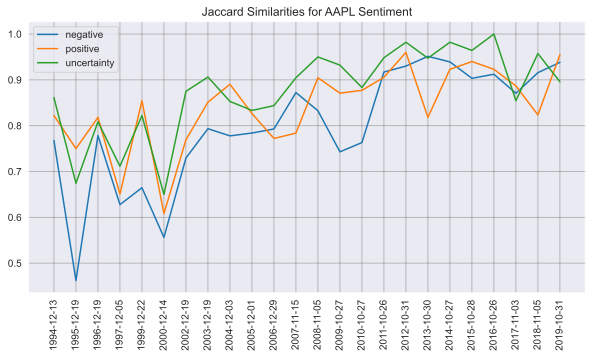

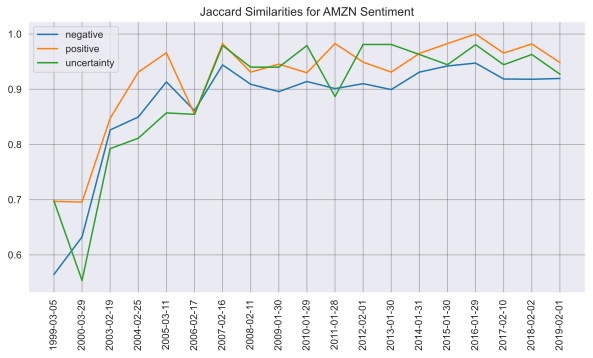

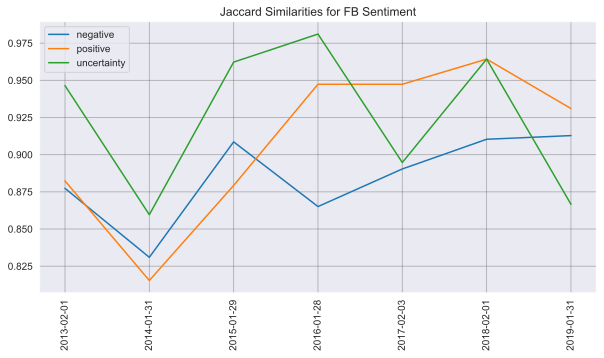

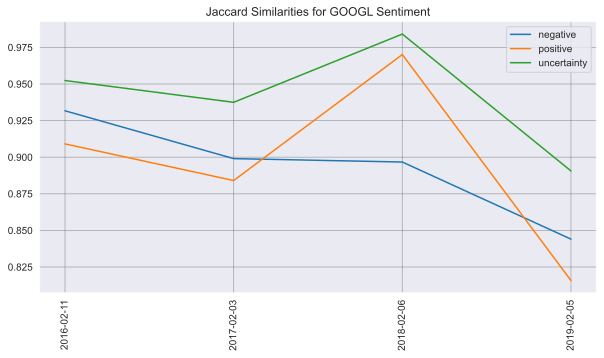

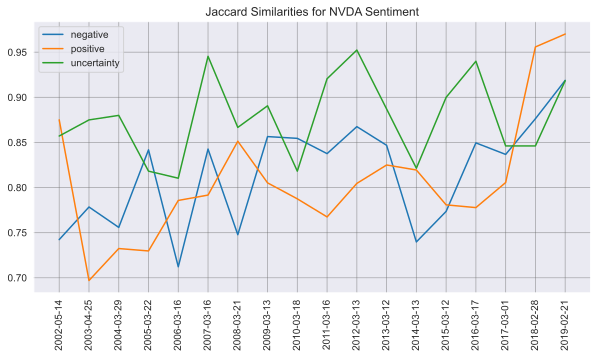

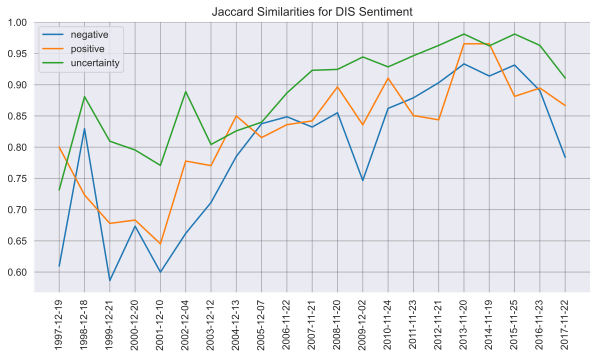

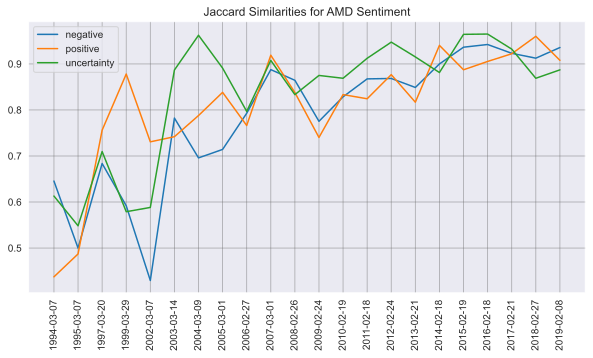

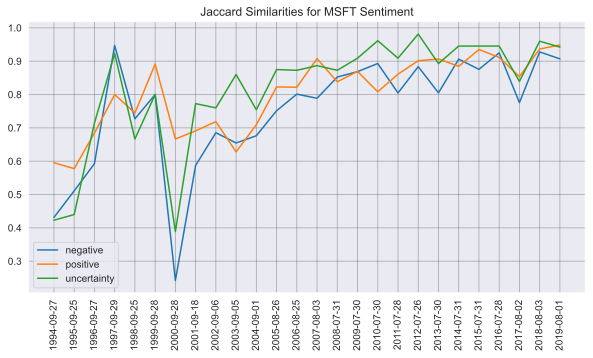

In [25]:
for ticker in cik_lookup.keys():
    plot_similarities(
        [jaccard_similarities[ticker][sentiment] for sentiment in sentiments],
        file_dates[ticker][1:],
        'Jaccard Similarities for {} Sentiment'.format(ticker),
        sentiments)
    plt.show()

### Cosine Similarity

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):    
    vectorizer = TfidfVectorizer(vocabulary= sentiment_words, ngram_range=(1,2))
    tfidf = vectorizer.fit_transform(docs).toarray()
    
    return tfidf

In [27]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    cosine_similarities = []
    cosine_similarities = list(np.diag(cosine_similarity(tfidf_matrix, tfidf_matrix), k=1))
    
    return cosine_similarities

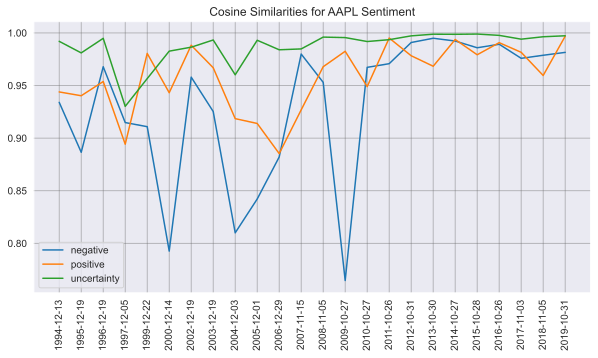

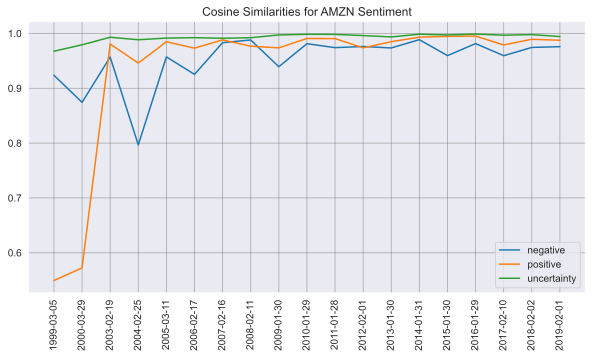

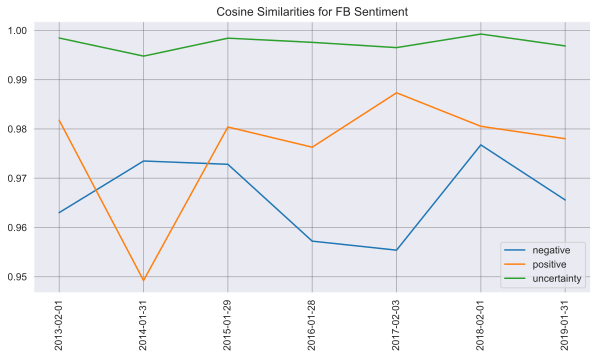

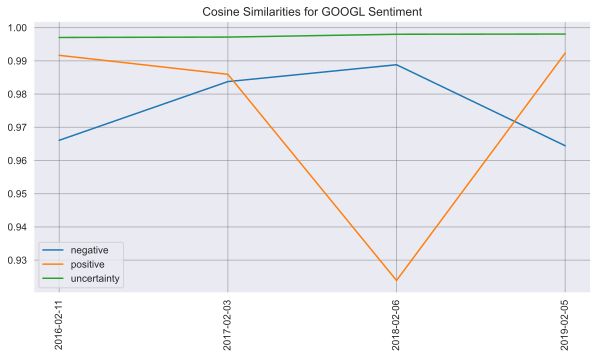

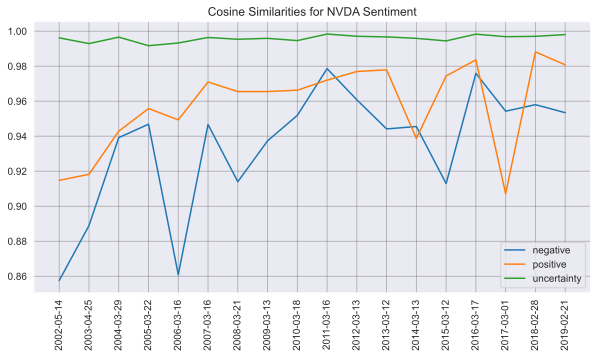

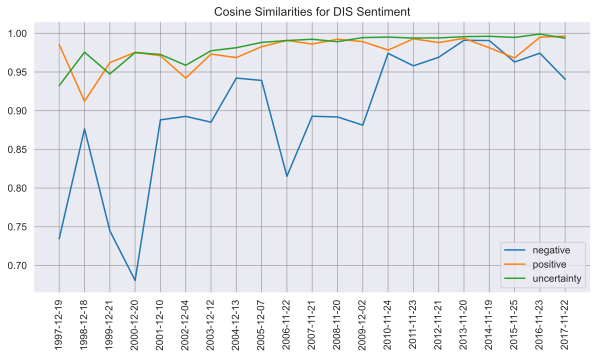

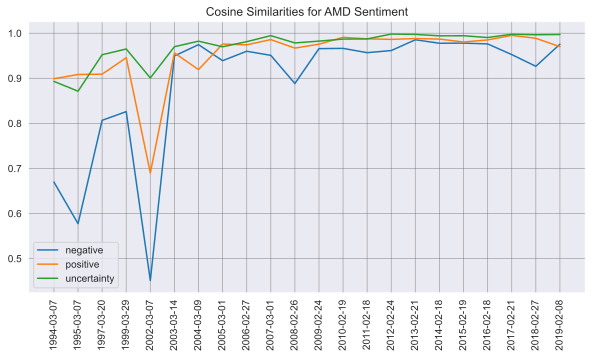

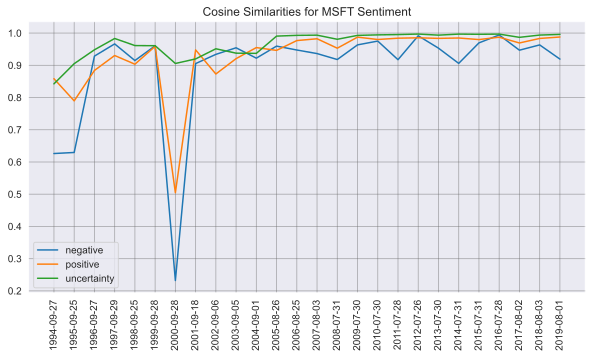

In [29]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


for ticker in cik_lookup.keys():
    plot_similarities(
        [cosine_similarities[ticker][sentiment] for sentiment in sentiments],
        file_dates[ticker][1:],
        'Cosine Similarities for {} Sentiment'.format(ticker),
        sentiments)
    plt.show()

### Looking at the similarity numbers

In [50]:
print(cik_lookup.keys())

dict_keys(['AAPL', 'AMZN', 'FB', 'GOOGL', 'NVDA', 'DIS', 'AMD', 'MSFT'])


In [51]:
ticker = 'AAPL'
similarities = pd.DataFrame(cosine_similarities[ticker], index=file_dates[ticker][1:])\
            .rename(columns={'negative':'cosine_negative', 'positive':'cosine_positive','uncertainty':'cosine_uncertainty'})\
            .join(pd.DataFrame(jaccard_similarities[ticker], index=file_dates[ticker][1:])\
            .rename(columns={'negative':'jaccard_negative', 'positive':'jaccard_positive','uncertainty':'jaccard_uncertainty'}))

In [54]:
similarities.pct_change(-1).mul(100) #Specify -1 to calculate pct change in reverse order

,cosine_negative,cosine_positive,cosine_uncertainty,jaccard_negative,jaccard_positive,jaccard_uncertainty
2019-10-31,0.279820,3.887058,0.092487,2.453988,15.909091,-6.435185
2018-11-05,0.296917,-2.244414,0.230524,5.161290,-7.133917,12.041648
2017-11-03,-1.351379,-0.927427,-0.361666,-4.548401,-3.930818,-14.545455
2016-10-26,0.339000,1.175281,-0.124744,0.982015,-1.800327,3.703704
2015-10-28,-0.645044,-1.461287,0.023372,-3.813503,1.833333,-1.818182
2014-10-27,-0.264985,2.626656,-0.009328,-1.274485,12.820513,3.670635
2013-10-30,0.407375,-1.018740,0.157609,2.284018,-14.772727,-3.540670
2012-10-31,2.073678,-1.691860,0.366271,1.415339,6.000000,3.571429
2011-10-26,0.359484,4.862350,0.175996,20.175271,3.245283,7.351984
2010-10-27,26.491824,-3.415978,-0.375714,2.714333,0.714750,-5.242424
